In [2]:
import ipywidgets
import scipy.linalg as lin
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/jithin/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['e']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
# %load cheb.py
from numpy import *
from numpy.fft import fft,ifft

def cheb(y):
    '''Chebyshev transform. Finds Chebyshev coefficients given y evaluated on
    Chebyshev grid'''
    N = len(y) - 1
    yt = real(fft(r_[y,y[-2:0:-1]]))
    yt = yt/(2*N)
    yt = r_[yt[0],yt[1:N]+yt[-1:N:-1],yt[N]]

    return yt

def icheb(c):
    '''Inverse Chebyshev transform. Evaluates Chebyshev series at the Chebyshev 
    grid points given Chebyshev coefficients.'''
    N = len(c) - 1
    y = r_[c[0],0.5*c[1:N],c[N],0.5*c[-1:N:-1]]
    y = y*2*N
    y = real(ifft(r_[y,y[-2:0:-1]]))[:N+1]

    return y


def Dcheb(y,interval):
    '''Chebyshev derivative of y evaluated on Chebyshev grid in interval [a,b]'''
    N = len(y) - 1
    a,b = interval
    x = 0.5*(b-a)*(cos(r_[0:N+1]*pi/N) + 1) + a

    k = r_[0:N]

    A = real(fft(r_[y,y[-2:0:-1]]))
    yy = real(ifft(1j*r_[k,0,-k[-1:0:-1]]*A))

    fact = 2.*(x-a)/(b-a)-1
    fact = fact[1:-1]
    yprime = -2./(b-a)*yy[1:N]/sqrt(1-fact**2)

    A = A/(2*N)
    A = r_[A[0],A[1:N]+A[-1:N:-1],A[N]]
    k = r_[0:N+1]

    yprime1 = sum(k**2*A)*2./(b-a)
    yprimeN = sum((-1)**(k+1)*k**2*A)*2./(b-a)

    return r_[yprime1,yprime,yprimeN]



def regrid(y,M):
    N = len(y) - 1
    a = cheb(y)
    if M==N:
        return y
    if M>N:
        a = r_[a,zeros(M-N)]
        return icheb(a)
    if M<N:
        a = a[:M+1]
        return icheb(a)



def clenshaw(x,c):
    '''Clenshaw algorithm to evaluate Chebyshev series at x
    assumes x is in [-1,1]'''
    N = len(c) - 1
    b = zeros(N+2)
    b[-1] = 0
    b[-2] = c[-1]
    for r in r_[N-1:0:-1]:
        b[r] = 2*x*b[r+1] - b[r+2] + c[r]
    s = x*b[1] - b[2] + c[0]

    return s


def clenshaw2(x,c,change_grid = True):
    '''Vectorized version of Clenshaw algorithm
    Use this for Chebyshev polynomial evaluation'''
    if change_grid:
    	if (min(x)!=-1) or (max(x)!=1):
        	x = 2*(x-min(x))/(max(x)-min(x)) - 1
    N = len(c) - 1
    b = zeros([N+2,len(x)])
    b[-1,:] = 0
    b[-2,:] = c[-1]
    for r in r_[N-1:0:-1]:
        b[r,:] = 2*x*b[r+1,:] - b[r+2,:] + c[r]
    s = x*b[1,:] - b[2,:] + c[0]

    return s



def chebD(c,interval):
    '''Finds derivative of Chebyshev series in spectral space
    i.e. maps c_n--->d_n where c_n,d_n are Chebyshev coefficients
    of f(x) and f'(x) in the interval [a,b].'''
    N = len(c) - 1
    a,b = interval
    if (a!=-1.) or (b!=1.):
        factor = 2./(b-a)
    else: 
        factor = 1.

    b = c*r_[0:N+1]


    cp = zeros_like(b)

    cp[0] = sum(b[1::2])

    evens = b[2::2]
    odds = b[1::2]

    cp[1:N+1-(N%2):2] = 2*cumsum(evens[-1::-1])[-1::-1]
    cp[2:N+1-((N+1)%2):2] = 2*cumsum(odds[-1::-1])[-2::-1]

    cp = cp*factor

    return cp


def chebD_semiinf(c):
    '''Finds the derivative of Chebyshev series in spectral space
    i.e. maps c_n --> d_n where c_n, d_n are Chebyshev coefficients
    of f(x) and f'(x) in the interval [0,oo)'''
    '''To be used only for the positive half-line'''
    
    N = len(c) - 1
    
    b = c*r_[0:N+1]


    cp = zeros_like(b)

    cp[0] = sum(b[1::2])

    evens = b[2::2]
    odds = b[1::2]

    cp[1:N+1-(N%2):2] = 2*cumsum(evens[-1::-1])[-1::-1]
    cp[2:N+1-((N+1)%2):2] = 2*cumsum(odds[-1::-1])[-2::-1]

    d0 = 3./4*cp[0] - cp[1]/2. + cp[2]/8.
    d1 = -cp[0] + 7./8*cp[1] - cp[2]/2. + cp[3]/8.
    d2 = cp[0]/4. - cp[1]/2. + 3./4*cp[2] - cp[3]/2. + cp[4]/8.
    d3 = cp[1]/8. - cp[2]/2. + 3./4*cp[3] - cp[4]/2. + cp[5]/8.
    
    dn = [ cp[i-2]/8. - cp[i-1]/2. + 3./4*cp[i] - cp[i+1]/2. + cp[i+2]/8.  for i in range(4,N-1)]

    dn1 = cp[N-1-2]/8. - cp[N-1-1]/2. + 3./4*cp[N-1] - cp[N-1+1]/2.
    
    dn2 = cp[N-2]/8. - cp[N-1]/2. + 3./4*cp[N]
    
    dn = r_[d0,d1,d2,d3,dn,dn1,dn2]

    return dn


def cheb2zD_semiinf(c):
    '''Finds the Chebyshev coefficients of the operator 2z df/dz when
    f has a series in Chebyshev rational functions Rn(z) = Tn((z-1)/(z+1)). Input
    is the coefficients of f.'''
    
    N = len(c) - 1
    
    b = c*r_[0:N+1]


    cp = zeros_like(b)

    cp[0] = sum(b[1::2])

    evens = b[2::2]
    odds = b[1::2]

    cp[1:N+1-(N%2):2] = 2*cumsum(evens[-1::-1])[-1::-1]
    cp[2:N+1-((N+1)%2):2] = 2*cumsum(odds[-1::-1])[-2::-1]

    d0 = -cp[2]/4. + cp[0]/2.
    d1 = cp[1]/4. - cp[3]/4.
    d2 = -cp[0]/2. + cp[2]/2. - cp[4]/4.
    
    dn = [ -cp[n-2]/4.  + cp[n]/2. - cp[n+2]/4 for n in range(3,N-1)] 
    
    dn1 = -cp[N-3]/4. + cp[N-1]/2
    dn2 = -cp[N-2]/4. + cp[N]/2
    
    dn = r_[d0,d1,d2,dn,dn1,dn2]
    
    return dn



def Intcheb(y,interval):
    '''Clenshaw-Curtis to find definite integral of function y(x) given at
    Chebyshev grid points in some interval [a,b]'''
    fact = 0.5*(interval[1]-interval[0])
    b = cheb(y)
    N = len(y) - 1
    if N%2 == 0:
        w = array([ 2./(-(2*k)**2+1) for k in r_[0:N/2+1]])
    else:
        w = array([ 2./(-(2*k)**2+1) for k in r_[0:(N-1)/2+1]])
    return dot(b[::2],w)*fact



def chebI(c,interval,x0=None,f0=None):
    if x0==None:
        x0=interval[0]

    N = len(c) - 1
    I = diag(1./(2*r_[0.5,r_[2:N+1]]),-1) -diag(1./(2*r_[1,r_[1:N]]),1)
    I[0,1] = 0
    
    factor = (interval[1]-interval[0])/2.
    
    ci = dot(I,c)*factor
    x = 2*(x0-interval[0])/(interval[1]-interval[0]) - 1
    
    if x==-1 and f0==None:
        ci[0] = -sum((-1)**r_[1:N+1]*ci[1:])
    else:
        ci[0] = f0 - clenshaw(x,ci)
    return ci



def cheb_convolve(a,b):
    '''Finds the product of two functions whose Chebyshev coefficients are 
    given by a and b. Output is the coefficiets of the product.'''

    M = len(b)
    N = len(a)
    
    if N>M:
        b = r_[b,zeros(N-M)]
        N = N - 1
    elif M>N:
        a = r_[a,zeros(M-N)]
        N = M - 1
    else:
        N = N - 1
    
    a[0] = a[0]*2.
    b[0] = b[0]*2.
        
    c0 = a[0]*b[0] + 2*dot(a[1:],b[1:])
    
    c1 = [ dot(a[0:k+1][::-1],b[0:k+1]) + dot(a[1:N-k+1],b[k+1:N+1]) + dot(a[k+1:N+1],b[1:N-k+1])  for k in range(1,N) ]

    c2 = [ dot(a[k-N:N+1][::-1],b[k-N:N+1])  for k in range(N,2*N+1)]
    
    c = r_[c0/2,c1,c2]/2.
    
    return c[:N+1]
    
def cosT(d,inverse=False):
    '''Finds the cosine transform of a given sequence'''
    b = []
    N = len(d)-1
    for n in r_[0:N+1]:
        b.append(sum(d*cos(n*r_[0:N+1]*pi/N)))
    b = array(b)
    if inverse:
        return b
    else:
        b[0] = b[0]/(N)
        b[1:] = b[1:]*2/(N)
        return b

In [3]:
def cintmatrix(N, interval=[-1,1]):
    A=np.eye(N)
    B=np.zeros((N,N))
    i=0
    for row in A:
        B[:,i]= chebI(chebI(row,interval,-1,0),interval,1,0)
        i+=1
    return B

In [4]:
N=5
Int = cintmatrix(N)
eig = lin.eigvals(Int)
p= -16/(eig*pi**2)
p.sort()
Int

array([[-1.25      ,  0.33333333,  0.47916667, -0.1875    ,  0.14583333],
       [ 1.        , -0.375     , -0.33333333,  0.25      , -0.16666667],
       [ 0.25      ,  0.        , -0.16666667,  0.        ,  0.04166667],
       [ 0.        ,  0.04166667,  0.        , -0.0625    ,  0.        ],
       [ 0.        ,  0.        ,  0.02083333,  0.        , -0.02083333]])

In [4]:
x = cos(np.pi*np.linspace(0,N-1,N)/(N-1))
y = exp(x)
u=cheb(y)
je=dot(Int,u)
j=np.empty((N,))
z=np.zeros((N,))
j[::2]=1
j[1::2]=-1
dot(j,je)
k=1
for i in range(N):
    if i % 2 == 0:
        if k == 1:
            k = 2
            z[i] = 1
        else:
            k = 1
            z[i] = -1
dot(z,je)
t=icheb(je)
plot( (1 - x)/exp(1) + exp(x) - exp(1))
plot(t)
dot(z,je)

NameError: name 'N' is not defined

In [5]:
def loader(i,N):
    e = np.zeros(N)
    e[i] = 1
    j=np.empty((N,))
    j[::2]=1
    j[1::2]=-1
    p = chebI(chebI(e,[-1,1],-1,0),[-1,1],1,0)
    return dot(p,j)

In [71]:
N= 7
w= empty(N)
for i in range(N):
    w[i] = loader(i,1000)
w

array([-2.        ,  0.66666667,  0.66666667, -0.4       ,  0.13333333,
       -0.0952381 ,  0.05714286])

In [6]:
N=15
e = np.zeros(N)
e[1] = -1
e[0] =  1
I = np.identity(N)
B = np.zeros((N+1,N+1))
B[0:N,0:N] = I
B[0:N,-1] = e
B[-1,-1] = 2
Int = cintmatrix(N)
A = np.zeros((N+1,N+1))
A[0:N,0:N] = Int
k = np.ones(N)
w = empty(N)
for i in range(N):
    w[i] = loader(i,1000) 
A[-1,0:N] = w

In [73]:
e= reshape(e, (N,1))
shape(e)
w= reshape(w,(1,N))
shape(w)
tild = 0.5*dot(e,w)
shape(tild)
MatI = Int - tild
Mat2 = I + tild

Method 1

In [74]:
lam1= lin.eigvals(A,B)
-4/(lam1*pi**2)

array([   1.00000000 -0.00000000e+00j,    4.00000000 -0.00000000e+00j,
          9.00000702 -0.00000000e+00j,   16.00000030 -0.00000000e+00j,
         24.98058038 -0.00000000e+00j,   36.00211944 -0.00000000e+00j,
         51.17871225 -0.00000000e+00j,   66.84189388 -0.00000000e+00j,
         67.53339691 -0.00000000e+00j,  122.53552881 -0.00000000e+00j,
        129.42001492 +1.50260041e+02j,  129.42001492 -1.50260041e+02j,
        302.99997770 -0.00000000e+00j, -511.23031146 +0.00000000e+00j,
        460.91919585 +1.29214147e+09j,  460.91919585 -1.29214147e+09j])

Method 2

In [14]:
lam2= lin.eigvals(MatI)
-4/((lam2*pi**2))

array([  1.00000000e+00    -0.j        ,   9.00000000e+00    -0.j        ,
         4.00000000e+00    -0.j        ,   2.50000000e+01    -0.j        ,
         4.90000000e+01    -0.j        ,   1.60000000e+01    -0.j        ,
         8.10000000e+01    -0.j        ,   3.60000000e+01    -0.j        ,
         1.21000000e+02    -0.j        ,   6.40000000e+01    -0.j        ,
         1.00000000e+02    -0.j        ,   1.69000000e+02    -0.j        ,
         1.44000000e+02    -0.j        ,   2.25000000e+02    -0.j        ,
         1.96000000e+02    -0.j        ,   2.89000000e+02    -0.j        ,
         2.56000000e+02    -0.j        ,   3.60999999e+02    -0.j        ,
         3.24000002e+02    -0.j        ,   4.41000034e+02    -0.j        ,
         3.99999840e+02    -0.j        ,   5.28999050e+02    -0.j        ,
         6.25015516e+02    -0.j        ,   4.84006698e+02    -0.j        ,
         7.28904305e+02    -0.j        ,   5.75847569e+02    -0.j        ,
         8.42953833e+02  

Method 3

In [15]:
lam3 = lin.eigvals(Mat2, Int)
-4/((lam2*pi**2))

/home/jithin/anaconda3/lib/python3.6/site-packages/scipy/linalg/decomp.py:60: RuntimeWarning: divide by zero encountered in true_divide
  w = (alphar + _I * alphai) / beta
/home/jithin/anaconda3/lib/python3.6/site-packages/scipy/linalg/decomp.py:60: RuntimeWarning: invalid value encountered in true_divide
  w = (alphar + _I * alphai) / beta


array([  1.00000000e+00    -0.j        ,   9.00000000e+00    -0.j        ,
         4.00000000e+00    -0.j        ,   2.50000000e+01    -0.j        ,
         4.90000000e+01    -0.j        ,   1.60000000e+01    -0.j        ,
         8.10000000e+01    -0.j        ,   3.60000000e+01    -0.j        ,
         1.21000000e+02    -0.j        ,   6.40000000e+01    -0.j        ,
         1.00000000e+02    -0.j        ,   1.69000000e+02    -0.j        ,
         1.44000000e+02    -0.j        ,   2.25000000e+02    -0.j        ,
         1.96000000e+02    -0.j        ,   2.89000000e+02    -0.j        ,
         2.56000000e+02    -0.j        ,   3.60999999e+02    -0.j        ,
         3.24000002e+02    -0.j        ,   4.41000034e+02    -0.j        ,
         3.99999840e+02    -0.j        ,   5.28999050e+02    -0.j        ,
         6.25015516e+02    -0.j        ,   4.84006698e+02    -0.j        ,
         7.28904305e+02    -0.j        ,   5.75847569e+02    -0.j        ,
         8.42953833e+02  

### Mixed boundary conditons

$y''=\lambda y$

y'(-1)=0,y(1)=0

$y(x)= \int_{1}^{x}\int_{-1}^{s}y(p)dpds$


$\frac{1}{\lambda}y(x)= Iy$

In [16]:
lam3= lin.eigvals(Int)
-1/(lam3*pi**2/16)

array([  1.00000000e+00-0.j,   9.00000000e+00-0.j,   2.50000000e+01-0.j,
         4.90000000e+01-0.j,   8.10000000e+01-0.j,   1.21000000e+02-0.j,
         1.69000000e+02-0.j,   2.25000000e+02-0.j,   2.89000000e+02-0.j,
         3.61000000e+02-0.j,   4.41000000e+02-0.j,   5.29000000e+02-0.j,
         6.25000000e+02-0.j,   7.29000000e+02-0.j,   8.41000000e+02-0.j,
         9.61000000e+02-0.j,   1.08900000e+03-0.j,   1.22500000e+03-0.j,
         1.36900000e+03-0.j,   1.52099999e+03-0.j,   1.68100004e+03-0.j,
         1.84900023e+03-0.j,   2.02499875e+03-0.j,   2.20899446e+03-0.j,
         2.40102335e+03-0.j,   2.60108283e+03-0.j,   2.80881997e+03-0.j,
         3.02482132e+03-0.j,   3.25276657e+03-0.j,   3.49362500e+03-0.j,
         3.74854695e+03-0.j,   4.04614267e+03-0.j,   4.42118778e+03-0.j,
         4.85635713e+03-0.j,   5.34562285e+03-0.j,   5.99221025e+03-0.j,
         6.88412175e+03-0.j,   7.93609816e+03-0.j,   9.13544779e+03-0.j,
         1.08754198e+04-0.j,  -1.45621241e+17+0.j, 

### Neumann Boundary conditions 

$y''=\lambda y$

y'(-1) = 0, y'(1) = 0

In [18]:
def wagon(i,N):
    e = np.zeros(N)
    e[i] = 1
    j=np.ones((N,)) # integral at 1
    p = chebI(chebI(chebI(e,[-1,1],-1,0),[-1,1],1,0),[-1,1],-1,0)
    return dot(p,j)

In [22]:
N=50
e = np.zeros(N)
e[0] = -1
I = np.identity(N)
B = np.zeros((N+1,N+1))
B[0:N,0:N] = I
B[0:N,-1] = e
B[-1,-1] = -2
Int = cintmatrix(N)
A = np.zeros((N+1,N+1))
A[0:N,0:N] = Int
k = np.ones(N)
w = empty(N)
for i in range(N):
    w[i] = wagon(i,1000) 
A[-1,0:N] = w

In [23]:
lam45= lin.eigvals(A,B)
-4/(lam45*pi**2)

array([  1.00000000e+00   -0.j        ,   4.00000000e+00   -0.j        ,
         9.00000000e+00   -0.j        ,   1.60000000e+01   -0.j        ,
         2.50000000e+01   -0.j        ,   3.60000000e+01   -0.j        ,
         4.90000000e+01   -0.j        ,   6.40000000e+01   -0.j        ,
         8.10000000e+01   -0.j        ,   1.00000000e+02   -0.j        ,
         1.21000000e+02   -0.j        ,   1.44000000e+02   -0.j        ,
         1.69000000e+02   -0.j        ,   1.96000000e+02   -0.j        ,
         2.25000000e+02   -0.j        ,   2.56000000e+02   -0.j        ,
         2.89000004e+02   -0.j        ,   3.24000002e+02   -0.j        ,
         3.60999422e+02   -0.j        ,   3.99999840e+02   -0.j        ,
         4.41037078e+02   -0.j        ,   4.84006754e+02   -0.j        ,
         5.27803613e+02   -0.j        ,   5.75871644e+02   -0.j        ,
         6.46991417e+02  +31.39904506j,   6.46991417e+02  -31.39904506j,
         6.74609910e+02   -0.j        ,   8.0281964

In [25]:
e= reshape(e, (N,1))
shape(e)
w= reshape(w,(1,N))
shape(w)
tild = -0.5*dot(e,w)
shape(tild)
MatI = Int - tild
Mat2 = I + tild
lam54= lin.eigvals(MatI)
-4/(lam54*pi**2)

array([  1.00000000e+00   -0.j        ,   4.00000000e+00   -0.j        ,
         9.00000000e+00   -0.j        ,   1.60000000e+01   -0.j        ,
         2.50000000e+01   -0.j        ,   3.60000000e+01   -0.j        ,
         4.90000000e+01   -0.j        ,   6.40000000e+01   -0.j        ,
         8.10000000e+01   -0.j        ,   1.00000000e+02   -0.j        ,
         1.21000000e+02   -0.j        ,   1.44000000e+02   -0.j        ,
         1.69000000e+02   -0.j        ,   1.96000000e+02   -0.j        ,
         2.25000000e+02   -0.j        ,   2.56000000e+02   -0.j        ,
         2.89000004e+02   -0.j        ,   3.24000002e+02   -0.j        ,
         3.60999422e+02   -0.j        ,   3.99999840e+02   -0.j        ,
         4.41037078e+02   -0.j        ,   4.84006754e+02   -0.j        ,
         5.27803613e+02   -0.j        ,   5.75871644e+02   -0.j        ,
         6.46991417e+02  +31.39904506j,   6.46991417e+02  -31.39904506j,
         6.74609910e+02   -0.j        ,   8.0281964

### The Heat equation

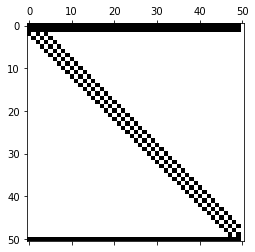

In [91]:
N = 50
Hint = cintmatrix(N)
dt = 0.1
I = dt*np.eye(N)
evec = np.zeros(N)
evec[0] = -1*dt
evec[1] =  1*dt
Amat = np.zeros((N+1,N+1))
Amat[0:N,0:N] = Hint -I
k = np.ones(N)
w = empty(N)
for i in range(N):
    w[i] = loader(i,1000) 
Amat[-1,0:N] = w
Amat[0:N,-1] = evec
Amat[-1,-1] = -2*dt
Bprior = np.zeros((N+1,N+1))
Bprior[0:N,0:N] = Hint
Bprior[-1,0:N] = w
spy(Bprior)

In [92]:
x = cos(np.pi*np.linspace(0,N-1,N)/(N-1))
y = np.sin(np.pi*x) 
u=cheb(y)
inp= np.zeros(N+1)
inp[0:N]=u
Bmat = np.dot(Bprior,inp)
p= lin.solve(Amat,Bmat)
q= np.exp(-np.pi**2*0.01) * np.sin(np.pi*x)

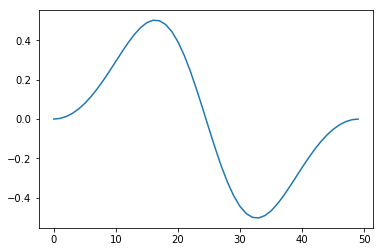

In [93]:
u = p[0:N]
q= icheb(p[0:N])
plot(q)

In [94]:
def uexact(x,t):
    return np.exp(-np.pi**2*t) * np.sin(np.pi*x)

In [95]:
def classic(figs,x,y,params):
    fig = figure()
    ax=plt.gca()
    for yelem in y:
        plt.plot(x,yelem)
    title('Time t = %g' % params[0])
    figs.append(fig)
    close(fig)
    return figs

In [96]:
error = []
figs = []
x = cos(np.pi*np.linspace(0,N-1,N)/(N-1))
y = np.sin(np.pi*x) 
u=cheb(y)
for i in range(1,100):
    inp[0:N]=u
    Bmat = np.dot(Bprior,inp)
    p= lin.solve(Amat,Bmat)
    u = p[0:N]
    q= icheb(p[0:N])
    t= i*dt
    qexact = uexact(x,t)
    figs=classic(figs,x,[q,qexact],[i*dt])
    error.append([lin.norm(q-qexact)])  

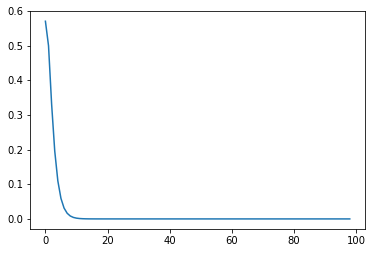

In [97]:
plot(error)

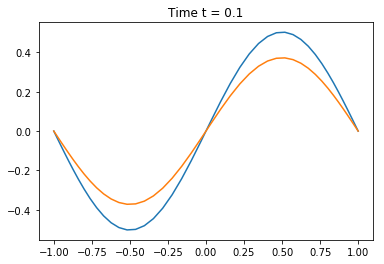

In [90]:
def display_frame(frameno): 
    display(figs[frameno])
    
widget = ipywidgets.IntSlider(min=0,max=len(figs)-1, value=0)
ipywidgets.interact(display_frame, frameno=widget)

### Rational Chebyshev functions

In [44]:
def rhs(Y,transform_factor):
    Yprime = Dcheb(Y,[-1,1])
    Yprime = transform_factor*Yprime  #Multiply by factor to get derivative on [0,oo)
    
    Yprime2 = Dcheb(Yprime,[-1,1])
    Yprime2 = transform_factor*Yprime2  #Multiply by factor to get derivative on [0,oo)
    
    Yprime[0],Yprime[-1] = 0,0       #Setting the value of yprime and yprime2 to zero at first and last grid points.
    Yprime2[0],Yprime2[-1]=0,0       #This way the end points of y do not get updated; they remain at zero.
    return Yprime2 

array([             inf,   4.85579918e+02,   2.14422917e+01,
         2.00000000e+00,   8.83162210e-02,   4.37818993e-02,
         2.22222222e-01,   3.76300393e-01,   4.69392127e-01,
         5.00000000e-01])

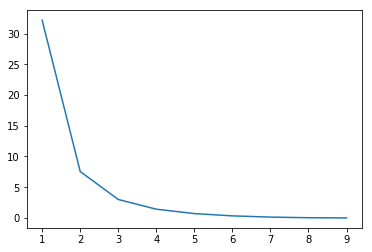

In [32]:
N = 10
z = cos(np.pi*np.linspace(0,N-1,N)/(N-1))
x = ((z[1:]+1)/(1-z[1:]))
x = r_[inf,x]
transform_factor = (1-x)**2/2
plot(x)
transform_factor

In [17]:
a0 = 1
a1 = 2
a2 = 3

In [5]:
def make_matrix(N):
    a0 = 0.75
    a1 = -1
    a2 = 0.25
    M = np.zeros((N,N))
    M[0:3,0]=[a0,a1,a2] #first column
    M[0:4,1]=[a1/2,a0+a2/2,a1/2,a2/2] #second column
    M[N-4:N,-2]=[a2/2,a1/2,a0,a1/2] #second last column
    M[N-3:N,-1]=[a2/2,a1/2,a0] #last column
    b=[a2/2,a1/2,a0,a1/2,a2/2]
    for i in range(2,N-2):
        M[i-2:i+3,i]=b
    return M

In [17]:
def cdiffmatrix(N, interval=[-1,1]):
    A=np.eye(N)
    B=np.zeros((N,N))
    i=0
    for row in A:
        B[i,:]= chebD(chebD(row,interval),interval)
        i+=1
    T=B.transpose() 
    return T

In [21]:
def cdiff1matrix(N, interval=[-1,1]):
    A=np.eye(N)
    B=np.zeros((N,N))
    i=0
    for row in A:
        B[i,:]= chebD(row,interval)
        i+=1
    T=B.transpose() 
    return T

In [127]:
N = 100
D = cdiff1matrix(N)
O = ones(N)
M = make_matrix(N)
T = dot(M,D)
z = cos(np.pi*np.linspace(0,N-1,N)/(N-1))
x = ((z[1:]+1)/(1-z[1:]))
x = r_[inf,x]
Init = exp(-x)
u = cheb(Init)
Diff = dot(T,T)
I = np.eye(N)
dt = 0.01
bdmat = I -dt*Diff

In [1]:
N = 100
z = cos(np.pi*np.linspace(0,N-1,N)/(N-1))
x = ((z[1:]+1)/(1-z[1:]))
def func(p,n):
    #p = ((x**3 - 15*x**2 +15*x -1)/((x+1)**3))#(x**2 - 6*x +2)/(x+1)**2
    for i in range(n):
        if i > 0:
            l = k[1]
            if k[1]>k[2]:
                p = p - ceil(l)/((x+1)**i)
            else :
                p = p - floor(l)/((x+1)**i)
        else:
            l = p[1]
            if p[1]>p[2]:
                p = p -  ceil(l)
            else:
                p = p -  floor(l)
        k = p*((x+1)**(i+1))
    return k[1]
p = (x**2 - 6*x +2)/(x+1)**2
q = ((x**3 - 15*x**2 +15*x -1)/((x+1)**3))
func(q,3)

NameError: name 'x' is not defined

/home/jithin/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in subtract
  if __name__ == '__main__':


-7.9977344407241571

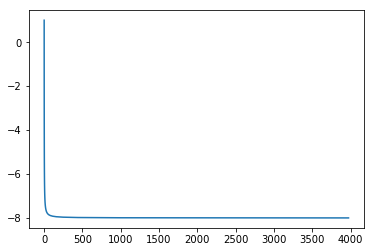

In [92]:
q = (x**2 - 6*x +2)/(x+1)**2 
p = q - 1
k = p*(x+1)
plot(x,p*(x+1))
k[1]

/home/jithin/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in subtract
  if __name__ == '__main__':


-17.987919044953017

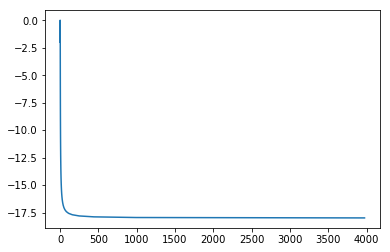

In [82]:
p = ((x**3 - 15*x**2 +15*x -1)/((x+1)**3)) -1
k = p*(x+1)
plot(x,p*(x+1))
k[1]


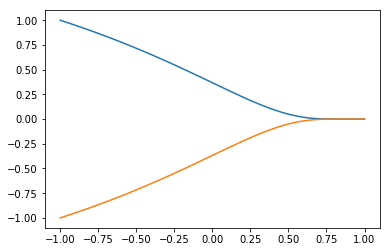

In [64]:
plot(z,Init)
ud = dot(T,u)
Finit = icheb(ud)
plot(z,Finit)

In [144]:
def make_BC(A,b,BC=[0,0]):
    N=len(b)
    g=np.ones((N,))
    j=np.empty((N,))
    j[::2]=1
    j[1::2]=-1
    A[-2,:]=j
    A[-1,:]=g
    b[-2]=BC[0]
    b[-1]=BC[1]
    return A,b

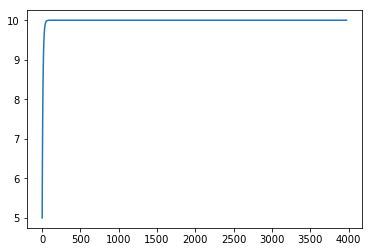

In [129]:

plot(x,Initial_condition)

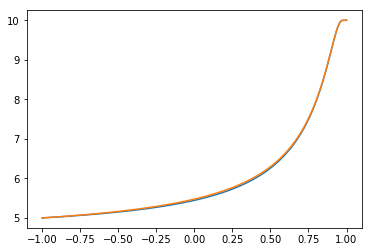

In [148]:
N = 1000
D = cdiff1matrix(N)
O = ones(N)
M = make_matrix(N)
T = dot(M,D)
z = cos(np.pi*np.linspace(0,N-1,N)/(N-1))
x = ((z[1:]+1)/(1-z[1:]))
x = r_[inf,x]
Diff = dot(T,T)
I = np.eye(N)
dt = 0.01
bdmat = I -dt*Diff
A = bdmat
Initial_condition = -5*exp(-0.1*x)+10
u = cheb(Initial_condition)
for i in range(100):
    b = u
    A,b = make_BC(A,b,[5,10])
    u = np.linalg.solve(A, b)
ure = icheb(u)
plot(z,ure)
plot(z,Initial_condition)


### Finding what to subtract

In [20]:
N = 100
z = np.cos(np.pi*np.linspace(0,N-1,N)/(N-1))
x = ((z[1:]+1)/(1-z[1:]))
def func(p,n):
    #p = ((x**3 - 15*x**2 +15*x -1)/((x+1)**3))#(x**2 - 6*x +2)/(x+1)**2
    for i in range(n):
        if i > 0:
            l = k[1]
            if k[1]>k[2]:
                p = p - np.ceil(l)/((x+1)**i)
            else :
                p = p - np.floor(l)/((x+1)**i)
        else:
            l = p[1]
            if p[1]>p[2]:
                p = p -  np.ceil(l)
            else:
                p = p -  np.floor(l)
        k = p*((x+1)**(i+1))
    return k[1]
p = (x**2 - 6*x +1)/(x+1)**2
q = ((x**3 - 15*x**2 +15*x -1)/((x+1)**3))
func(q,2)
u=cheb(p)
ud = 2*chebD(u,[-1,1])
sum(ud)

29.539117945959301

In [22]:
N = 100
D = cdiff1matrix(N)
O = ones(N)
M = make_matrix(N)
T = dot(M,D)

NameError: name 'make_matrix' is not defined

In [26]:
N = 101
z = np.cos(np.pi*np.linspace(0,N-1,N)/(N-1))
x = ((z[1:]+1)/(1-z[1:]))
p = (x**2 - 6*x +1)/(x+1)**2
size(p)

100

In [30]:
p = (x**2 - 6*x +1)/(x+1)**2
u=cheb(p)
ud2 = dot(D,p)
sum(ud2)

55577.261778219108

In [4]:
from sympy import *

In [5]:
var('t')

t

In [7]:
f = (t**2 - 6*t +1)/(t+1)**2 
apart(f)

1 - 8/(t + 1) + 8/(t + 1)**2

In [15]:
g =(t**3 - 15*t**2 +15*t -1)/((t+1)**3)
qq =apart(g)
qq

1 - 18/(t + 1) + 48/(t + 1)**2 - 32/(t + 1)**3

In [14]:
qq.coeff(1/(t+1))

-18

In [16]:
r4 = (t**4 -28*t**3+70*t**2-28*t+1 )/(t+1)**4
apart(r4)

1 - 32/(t + 1) + 160/(t + 1)**2 - 256/(t + 1)**3 + 128/(t + 1)**4

### The integral

In [6]:
def pfexp(e,n):
    for i in range(1,n):
        e = -(chebD(e,[-1,1]))*(2/i)
    return sum(e)
def part_coeff(e,N):
    k = empty(N)
    for n in range(1,N+1):
        k[n-1] = pfexp(e,n)
    return k
        
e = [0,0,0,0,1]
part_coeff(e,6)
N=1000
z = np.cos(np.pi*np.linspace(0,N-1,N)/(N-1))
x = ((z[1:]+1)/(1-z[1:]))
p = 1/(1+x)#exp(-x)
t= cheb(p)
g = zeros(1000)
g[1] = 1
tol = 0.00001
t[abs(t)<tol]= 0
part_coeff(g,5)

array([ 1., -2.,  0.,  0.,  0.])

In [7]:
def pfexp(e,n):
    for i in range(1,n):
        e = -(chebD(e,[-1,1]))*(2/i)
    return sum(e)
e = (x-1)/(1+x)
t = cheb(e)
pfexp(t,2)

-7.5300589870475942

In [5]:
def make_matrix(N):
    a0 = 0.75
    a1 = -1
    a2 = 0.25
    M = np.zeros((N,N))
    M[0:3,0]=[a0,a1,a2] #first column
    M[0:4,1]=[a1/2,a0+a2/2,a1/2,a2/2] #second column
    M[N-4:N,-2]=[a2/2,a1/2,a0,a1/2] #second last column
    M[N-3:N,-1]=[a2/2,a1/2,a0] #last column
    b=[a2/2,a1/2,a0,a1/2,a2/2]
    for i in range(2,N-2):
        M[i-2:i+3,i]=b
    return M
make_matrix(5)

array([[ 0.75 , -0.5  ,  0.125,  0.   ,  0.   ],
       [-1.   ,  0.875, -0.5  ,  0.125,  0.   ],
       [ 0.25 , -0.5  ,  0.75 , -0.5  ,  0.125],
       [ 0.   ,  0.125, -0.5  ,  0.75 , -0.5  ],
       [ 0.   ,  0.   ,  0.125, -0.5  ,  0.75 ]])

In [10]:
def make_matrix1(N):
    a0 = 0.5
    a1 =-0.25
    M = np.zeros((N,N))
    M[0:2,0]=[a0,2*a1] #first column
    M[N-2:N,-1]=[a1,a0] #last column
    b=[a1,a0,a1]
    for i in range(1,N-1):
        M[i-1:i+2,i]=b
    return M
N=5
M = make_matrix1(N)
M2 = dot(M,M)
M3 = dot(M2,M)
e = zeros(N)
e[0] = 1
q = dot(M3,e)
M
q

array([ 0.3125 , -0.46875,  0.1875 , -0.03125,  0.     ])

This function returns the Chebyshev coefficients of  $\frac{1}{(1+x)^N}$. 

For example,  N = 1 or $\frac{1}{1+x}$ gives [0.5 -0.5]

In [11]:
def supmat(N):
    M = make_matrix1(1000)
    K = M
    for i in range(N-1):
        U = dot(K,M)
        K = U
    e = zeros(1000)
    e[0] = 1
    q = dot(K,e)
    return q

In [12]:
supmat(3)[0:4]

array([ 0.3125 , -0.46875,  0.1875 , -0.03125])

In [13]:
def bmatrix(N):
    B = np.zeros((N,N))
    B[0,0] = 1
    for i in range(1,N):
        B[0:i+1,i]=supmat(i)[0:i+1]
    return B

In [16]:
N=3000
z = np.cos(np.pi*np.linspace(0,N-1,N)/(N-1))
x = ((z[1:]+1)/(1-z[1:]))
p = 1/(1+x)**2
r = cheb(p)
tol = 0.0001
r[abs(r)<tol] = 0
p = part_coeff(r,8)
c = p[2:]
c

array([ 0.99894383,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

# this one takes time

In [17]:
B = bmatrix(6)
q = dot(B,c)
q

array([ 0.99894383,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [22]:
c=zeros(N)
c= [ 0.375, -0.5  ,  0.125,  0  ,  0, 0   ]
c= [ 0.5, -0.5  ,  0,  0  ,  0, 0   ]
q = dot(B,c)
q

array([ 0.25,  0.25,  0.  ,  0.  ,  0.  ,  0.  ])

In [19]:

Int = chebI(q,[-1,1],-1,0)
sum(Int)
0.5*Int

array([ 0.49947191,  0.49947191,  0.        ,  0.        ,  0.        ,  0.        ])

### The alternate method

We assume 
$$ \sum_n c_n R_n = \frac{1}{(1+x)^2} \sum_n b_n R_n $$

alt_matrix is used to construct the $ b_n $ s from $ R_n $ s

In [3]:
def alt_matrix(N):
    if N < 5:
        print("Make N >= 5")
    else:
        t0,t1,t1=3/4,1/2,1/8
        A = np.zeros((N,N))
        A[0,0] = 1/16
        A[1,0:2] = [-1/4,1/16]
        A[2,0:3] = [3/8,-1/4,1/16]
        A[3,0:4] = [-1/4,3/8,-1/4,1/16]
        A[4,0:5] = [1/16,-1/4,3/8,-1/4,1/16]
        for i in range(5,N):
            A[i,i-4:i+1] = [1/16,-1/4,3/8,-1/4,1/16]
        A[-1,-5:] = [1/16,-1/4,3/8,-1/4,1/8]
        return A
N = 10
K =alt_matrix(N)
c=zeros(N)
#c[-80]=1
solve(K,c)
w= dot(lin.inv(K),c)
w = w[::-1]
p=lin.inv(K)
p[p<10**(-10)]=0
p[:,0]

array([   16.,    64.,   160.,   320.,   560.,   896.,  1344.,  1920.,
        2640.,  1760.])

In [4]:
def nate_matrix(N):
    M = zeros((N,N))
    K =[16,64,160,320,560]
    d = [-1,4,-6,4]
    for i in range(N):
        K = K+[dot(d,K[-4:])]
        M = M + K[i]*eye(N,N,-i)
    M[-1,:]=0.5*M[-1,:]   
    return M

In [3]:
#from scipy.sparse import diags
N = 7
M = zeros((N,N))
K =[16,64,160,320,560]
d = [-1,4,-6,4]
for i in range(N):
    K = K+[dot(d,K[-4:])]
    M = M + K[i]*eye(N,N,-i)
M[-1,:]=0.5*M[-1,:]
M

array([[  16.,    0.,    0.,    0.,    0.,    0.,    0.],
       [  64.,   16.,    0.,    0.,    0.,    0.,    0.],
       [ 160.,   64.,   16.,    0.,    0.,    0.,    0.],
       [ 320.,  160.,   64.,   16.,    0.,    0.,    0.],
       [ 560.,  320.,  160.,   64.,   16.,    0.,    0.],
       [ 896.,  560.,  320.,  160.,   64.,   16.,    0.],
       [ 672.,  448.,  280.,  160.,   80.,   32.,    8.]])

We test it on

$$ p =  \frac{1}{(1+x)^2} $$


In [112]:
p = 8/(1+x)**2
cheb(p)[:4]

array([ 3.03061224, -4.00640737,  0.96777402,  0.00576237])

In [119]:
N=100
z = np.cos(np.pi*np.linspace(0,N-1,N)/(N-1))
x = ((z[1:]+1)/(1-z[1:]))
r=zeros(N+2)
r[0] = 3/8
r[1] = -0.5
r[2] = 1/8
r[:4]= [0.3125 , -0.46875,  0.1875 , -0.03125]
c = r[2:]
#c=zeros(N)
#c[0]=1
rc = c[::-1]
A = alt_matrix(len(rc))
invA = lin.inv(A)
invA[invA<10**(-4)]=0
ra2 = dot(M,rc)
ra = solve(A,rc)
a = ra[::-1]
a2 = ra2[::-1]
a2[:10]
a2[:10]

array([ 0.5, -0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ])

For the integral, we need $\frac{2}{(1+x)^2}$
So, we divide the coefficients by 2 and use chebI

In [120]:
a = a2/2
Int = chebI(a,[-1,1],-1,0)
sum(Int)

0.5

The function integrator consolidates this and also returns b which are the coefficients of the terms that blow up when integrated.

In [130]:
def integrator(c,b=[]):
    a0 = sum(c)
    a1 = sum(-(chebD(c,[-1,1]))*2)
    r = c[2:]
    rc = r[::-1]
    #rc[rc<0.001]=0
    A = nate_matrix(len(rc))
    #ra = solve(A,rc)
    ra = np.dot(A,rc)
    a = ra[::-1]
    a=a/2
    Int = chebI(a,[-1,1],-1,0)
    b = [a0,a1] +b
    return Int,b

In [6]:
def alligrator(c,M,b=[]):
    a0 = sum(c)
    a1 = sum(-(chebD(c,[-1,1]))*2)
    #r =zeros(len(c))
    r = c[2:]
    rc = r[::-1]
    ra = np.dot(M,rc)
    a = ra[::-1]
    a=a/2
    Int = chebI(a,[-1,1],-1,0)
    b = [a0,a1] +b
    return Int,b

$$ p = \frac{1}{(1+x)^2}$$

In [137]:
N=500
z = np.cos(np.pi*np.linspace(0,N-1,N)/(N-1))
x = ((z[1:]+1)/(1-z[1:]))
p = 1/(1+x)**2 #exp(-x)
c = zeros(N)
c[:3] = [3/8,-0.5,1/8]#cheb(p)
r=zeros(N)
r[6] = 1
Int,b = integrator(c,[])
b


[0.0, 0.0]

In [138]:
Int[:10]

array([ 0.5,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ])

In [139]:
Int1,b1 = integrator(Int,b)
b1

[1.0, -1.0, 0.0, 0.0]

In [140]:
Int1[:10]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

These values are supposed to be zeros since there are no higher order terms left to integrate.
This is probably because the alt_matrix is ill-posed

In [141]:
Int2,b2 = integrator(Int1,b1)
b2

[0.0, 0.0, 1.0, -1.0, 0.0, 0.0]

The first two values are supposed to be zero. But they come from the error terms in the previous step.

Putting a tolerance value solves these problems for $\frac{1}{(1+x)^2}$ but not for $\frac{1}{(1+x)^4}$

In [12]:
def basis(N):
    A=np.eye(N)
    B=np.zeros((N-2,N))
    M=nate_matrix(N-2)
    i=0
    for row in A:
        B[:,i],k= alligrator(row,M)
        i+=1
    return B

array([ 14.,  16.,   2.,   0.,   0.])